# 异常值

**异常值（Outlier）**是指数据集中明显偏离其他观测值的极端值，可能由测量误差、数据录入错误或真实但罕见的事件引起。

## 泰坦尼克数据集

**titanic 数据集**包含了 891 条乘客记录，每条记录描述了乘客的个人信息及其在 Titanic 号上的生存情况
- survived：生存情况（0 = 未生还, 1 = 生还）
- pclass：乘客舱等级（1 = 一等舱, 2 = 二等舱, 3 = 三等舱）
- sex：乘客性别（male = 男性, female = 女性）
- age：乘客年龄（float，部分缺失值）
- sibsp：乘客在船上的兄弟姐妹或配偶数量（整数）
- parch：乘客在船上的父母或子女数量（整数）
- fare：乘客支付的票价（float）
- embarked：乘客登船港口（C = 瑟堡, Q = 皇后镇, S = 南安普敦）
- class：舱等级（文本版本的 pclass，First = 头等舱, Second = 二等舱, Third = 三等舱）
- who：乘客身份（man = 成年男性, woman = 成年女性, child = 儿童）
- adult_male：是否为成年男性（True = 是, False = 否）
- deck：乘客所在的甲板（A, B, C, D, E, F, G，部分缺失值较多）
- embark_town：乘客登船的城市（Cherbourg = 瑟堡, Queenstown = 皇后镇, Southampton = 南安普敦）
- alone：是否独自旅行（True = 独自旅行，False = 有亲属同行，对应 sibsp + parch == 0）

In [21]:
# 导入必要的库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# 加载seaborn内置的泰坦尼克数据集
df = sns.load_dataset('titanic')

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


# 异常值检测方法

## 基于统计的方法

### Z-Score（标准化得分）

- 计算数据点与均值的标准差距离：$$Z = \frac{X - \mu}{\sigma}$$
- 通常认为$|Z| > 3$为异常值（可根据需求调整阈值）。
- **适用场景**：数据近似服从正态分布。

In [22]:
df['age'].mean()

29.69911764705882

In [23]:
df['age'].std()

14.526497332334044

In [24]:
# 计算年龄的Z-Score（标准化得分）
df['age_zscore'] = (df['age'] - df['age'].mean()) / df['age'].std()

# 定义异常值阈值（通常|Z| > 3为异常）
z_threshold = 3
age_outliers = df[df['age_zscore'].abs() > z_threshold]

age_outliers

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,age_zscore
630,1,1,male,80.0,0,0,30.000,S,First,man,True,A,Southampton,yes,True,3.462699
851,0,3,male,74.0,0,0,7.775,S,Third,man,True,NaN,Southampton,no,True,3.049660


### IQR（四分位距）法

- 计算四分位距IQR = Q3 - Q1（Q1为25%分位数，Q3为75%分位数）。
- 异常值范围：$[Q1 - 1.5 \times IQR,\ Q3 + 1.5 \times IQR]$之外的数据点。
- **适用场景**：数据分布偏斜或存在极端值。

[IQR] age异常值数量: 11
异常age范围: 65.0 ~ 80.0


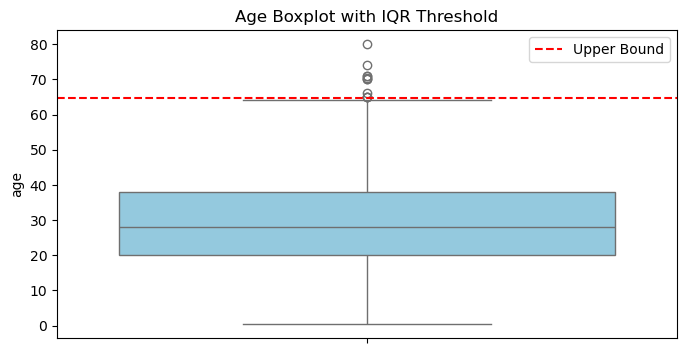

In [25]:
# 计算age的四分位数和IQR
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常值边界（1.5倍IQR是常用阈值）
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 标记age异常值
fare_outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]

# 输出结果
print(f"[IQR] age异常值数量: {len(fare_outliers)}")
print(f"异常age范围: {fare_outliers['age'].min()} ~ {fare_outliers['age'].max()}")

# 绘制箱线图对比
plt.figure(figsize=(8, 4))
sns.boxplot(y=df['age'], color='skyblue')
plt.axhline(y=upper_bound, color='red', linestyle='--', label='Upper Bound')
plt.title('Age Boxplot with IQR Threshold')
plt.legend()
plt.show()

### 修正的Z-Score（MAD）

- 使用中位数和绝对中位差（MAD）替代均值和标准差：$$\text{MAD} = \text{median}(|X_i - \text{median}(X)|)$$
$$\text{修正Z} = \frac{0.6745 \times (X_i - \text{median}(X))}{\text{MAD}}$$
- 阈值通常设为3.5。
- **适用场景**：数据存在严重偏态或离群点。

[MAD] fare异常值数量: 114


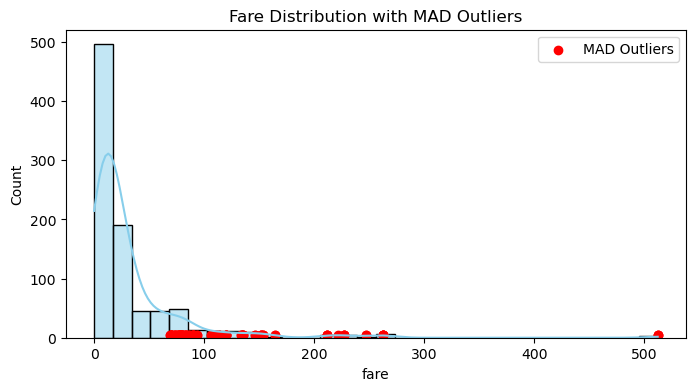

In [26]:
from scipy.stats import median_abs_deviation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 计算修正的Z-Score（基于中位数和MAD）
def modified_zscore(x, threshold=3.5):
    median = np.median(x)
    mad = median_abs_deviation(x, scale='normal')
    modified_z = 0.6745 * (x - median) / mad       # 修正因子0.6745
    return np.abs(modified_z) > threshold

# 检测fare的MAD异常值（确保处理非空值）
fare_clean = df['fare'].dropna()
is_outlier = modified_zscore(fare_clean)  # 对非空值计算异常值标记

# 获取异常值数据（需要对齐索引）
fare_mad_outliers = fare_clean[is_outlier]  # 直接使用清洗后的Series

print(f"[MAD] fare异常值数量: {len(fare_mad_outliers)}")

# 可视化
plt.figure(figsize=(8, 4))
sns.histplot(fare_clean, kde=True, bins=30, color='skyblue')
plt.scatter(fare_mad_outliers, [5]*len(fare_mad_outliers), 
            color='red', label='MAD Outliers')
plt.title('Fare Distribution with MAD Outliers')
plt.legend()
plt.show()

## 基于距离的方法

### 局部异常因子（LOF）

LocalOutlierFactor（局部异常因子，简称 LOF）是一种用于**异常检测（outlier detection）**的无监督学习算法，主要应用在发现数据集中密度显著低于邻居的“异常点”。

其核心思想是：如果一个点的密度远小于其邻居，就可能是异常点。

#### 基本原理
LOF 基于 局部密度（local density） 来判断一个点是否是异常点：
- **邻居距离**：先找到每个点的 k 个最近邻。
- **局部可达密度（local reachability density）**：计算一个点与其邻居之间的可达密度。
- **LOF 得分**：将该点的局部密度与邻居的平均局部密度进行比较。
    - 如果该点密度比邻居低很多 → LOF 得分大于 1，说明它是异常点。
    - LOF 越大，异常性越强。

#### LOF 得分的意义
- LOF ≈ 1：点与周围密度差不多，是“正常”的。
- LOF > 1：点的密度比周围低，可能是异常。
- LOF ≫ 1（如 1.5, 2, 3...）：高度异常。

#### 优缺点
- 优点
    - 可检测“局部”异常，而不是只看全局。
    - 不需要提前定义异常规则。
    - 对非线性和高维数据有一定鲁棒性。
- 缺点
    - 计算复杂度较高，尤其是在大数据集下。
    - 参数选择（如邻居数量 n_neighbors）对结果影响较大。
    - 不适用于实时预测（除非设置 novelty=True 并提前训练）。

#### LocalOutlierFactor()
- `n_neighbors`: 用于计算局部密度的邻居数量。
  - 这个值越大，计算的“局部”范围越大。太小容易受噪声影响，太大可能掩盖局部异常。
- `algorithm`: 用于计算最近邻的算法。
  - `auto`: 自动选择最合适的算法。
  - `ball_tree`、`kd_tree`: 使用树结构加速。
  - `brute`: 暴力搜索（适用于小数据集）。
- `contamination`: 数据中异常点所占的比例。
    - `auto`: 自动估计
    - 数值（如 0.1）: 表示数据中有 10% 的点是异常的。
- `novelty`: 是否用于新数据的预测。
    - `False`: 默认值。只能对训练数据进行异常检测（适用于无监督异常检测）。
    - `True`: 模型可以用于新样本的预测（半监督，需要训练时数据无异常）。
- `n_jobs`: 用于计算的 CPU 核心数。
    - `None`: 默认值，仅使用一个核心
    - `-1`: 使用所有核心
    - `2`、`4`等整数: 使用对应数量的核心

#### LocalOutlierFactor()方法
- `fit(X)`: 训练模型。
    - 参数：X 是输入样本（形状为 [n_samples, n_features]）。
    - 说明：只适用于 novelty=False 模式下，对训练数据建模，用于检测“已知数据”中的异常点。
- `fit_predict(X)`: 训练模型并返回每个样本的异常预测结果。
    - 返回值：数组，元素为 1（正常）或 -1（异常）。
    - 说明：只适用于无监督场景（novelty=False），不能用于新样本。
- `predict(X)`: 预测新数据是否是异常。
    - 返回值：1 表示正常，-1 表示异常。
    - 注意：只能在 novelty=True 时使用，即先 fit() 一组“正常数据”，再对新样本 predict()。
- `decision_function(X)`: 返回每个样本的异常程度得分（越小越可能是异常）。
    - 值越小表示越“异常”。
    - 通常是 LOF 得分的反向量：-LOF(X)
    - 只可用于 novelty=True 模式。

#### 代码实现

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
# 选择数值特征并标准化（LOF对尺度敏感）
features = ['age', 'fare']
X = df[features].copy()

# 填充缺失值（用中位数）
X['age'].fillna(X['age'].median(), inplace=True)

# 标准化数据（Z-Scale）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用LOF检测异常值（n_neighbors=5）
LOF = LocalOutlierFactor(n_neighbors=5)
outlier_labels = LOF.fit_predict(X_scaled)  # -1表示异常值

# 将结果添加到DataFrame
df['LOF_outlier'] = outlier_labels
LOF_outliers = df[df['LOF_outlier'] == -1]

# 输出结果
print(f"[LOF] 异常值数量: {len(LOF_outliers)}")

[LOF] 异常值数量: 143


### DBSCAN聚类

#### 基本原理
**DBSCAN（Density-Based Spatial Clustering of Applications with Noise）**是一种基于密度的聚类算法，可以自动识别出数据中的高密度区域（簇）并标记低密度区域为噪声（离群点）。

其核心思想是：在样本空间中，如果一个点周围的邻居数量不足，它就无法形成“密度可达”的聚类，因而可能是异常点。

#### 算法流程
DBSCAN 通过密度评估来识别“核心点”、“边界点”与“噪声点”：
   - **ε 邻域（eps）**：一个点的半径为 eps 的邻域内的所有点，构成其直接邻居。
   - **核心点（core point）**：如果某个点的 eps 邻域中包含的点数 ≥ min_samples，它被认为处于一个密度高的区域，是核心点。
   - **边界点（border point）**：不满足核心点条件，但在某个核心点的 eps 邻域中。
   - **噪声点（noise / outlier）**：既不是核心点，也不是边界点，无法归为任何聚类，被视为异常点。

#### 优缺点
- 优点
    - 不需要预先指定聚类数量（不像 K-Means）。
    - 能识别任意形状的簇（非球形也可以）。
    - 可以检测噪声点，鲁棒性强。
    - 对小数据集或低维度聚类效果优秀。
- 缺点
    - 对参数 eps（半径） 和 min_samples（最小邻居数）敏感。
    - 不适用于高维数据，因“距离”在高维空间失效（维度灾难）。
    - 对密度变化大的簇可能无法正确划分。

#### DBSCAN()

- `eps`: 邻域的最大距离：两个样本要被归为同一簇，其距离必须小于等于这个值。默认值是 0.5。
- `min_samples`: 构成一个核心点所需要的最小样本数（包括点本身）。默认值是 5。
- `metric`:用于计算距离的度量方式，默认为 'euclidean'（欧几里得距离）。
- `algorithm`: 用于计算最近邻的算法。
  - `auto`: 自动选择最合适的算法。
  - `ball_tree`、`kd_tree`: 使用树结构加速。
  - `brute`: 暴力搜索（适用于小数据集）。
- `n_jobs`: 用于计算的 CPU 核心数。
    - `None`: 默认值，仅使用一个核心
    - `-1`: 使用所有核心
    - `2`、`4`等整数: 使用对应数量的核心

#### DBSCAN()方法

| 方法名                         | 说明                                                      |
| --------------------------- | ------------------------------------------------------- |
| **`.fit(X)`**               | 拟合模型，对数据集 `X` 进行聚类，不返回标签。只训练模型。                         |
| **`.fit_predict(X)`**       | 拟合模型并返回每个样本的聚类标签数组。常用于快速聚类分析。                           |
| **`.fit_transform(X)`**     | 同 `.fit_predict()`，因为聚类没有“转换”意义，这里等效于 `.fit_predict()`。 |
| **`.get_params()`**         | 返回模型初始化时的参数字典，用于查看或调试模型设置。                              |

#### DBSCAN()属性

| 属性名                         | 含义                                                |
| --------------------------- | ------------------------------------------------- |
| **`.labels_`**              | 每个样本对应的聚类标签：整数值（如 0,1,2,...），噪声点标记为 `-1`。         |
| **`.core_sample_indices_`** | 所有核心点在原始数据中的索引。可用于提取聚类“中心”。                       |
| **`.components_`**          | 所有核心点的实际数据点数组，形状为 `[n_core_samples, n_features]`。 |
| **`.n_features_in_`**       | 输入数据的特征维度数（从 v0.24 开始支持）。                         |

#### 代码实现

[DBSCAN] 异常值数量: 22


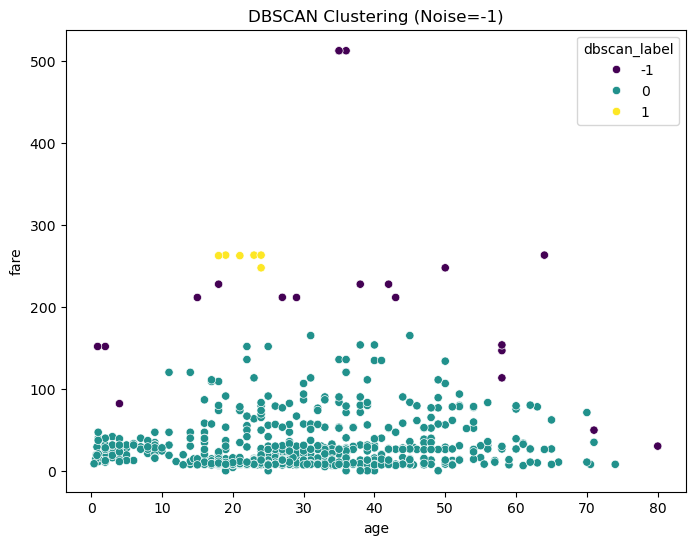

In [28]:
from sklearn.cluster import DBSCAN

# 数据预处理（选择年龄和票价，标准化）
X_dbscan = df[['age', 'fare']].copy()
X_dbscan['age'].fillna(X_dbscan['age'].median(), inplace=True)
X_dbscan_scaled = StandardScaler().fit_transform(X_dbscan)

# DBSCAN聚类（eps=0.5, min_samples=5）
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_label'] = dbscan.fit_predict(X_dbscan_scaled)

# 标记噪声点（-1）为异常值
dbscan_outliers = df[df['dbscan_label'] == -1]
print(f"[DBSCAN] 异常值数量: {len(dbscan_outliers)}")

# 可视化聚类结果
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['age'], y=df['fare'], hue=df['dbscan_label'], palette='viridis')
plt.title('DBSCAN Clustering (Noise=-1)')
plt.show()

## 基于模型的方法

### 孤立森林（Isolation Forest）

#### 基本原理

**孤立森林（Isolation Forest）**是一种用于异常检测（outlier detection）的无监督学习算法，尤其适合处理高维大规模数据集中的异常点识别。

其核心思想是：异常点更容易被“孤立”。通过构造多个随机树（Isolation Trees），来衡量一个样本被分离的“容易程度”，以此判断是否异常。

#### 算法流程

Isolation Forest 通过构造**随机树（isolation trees）**将数据递归切分。异常值倾向于更快地被分离。

- **构造随机切分树**：
    - 每棵树从特征中随机选一个维度，并在该维度上随机选一个切分值，将数据分裂。
    - 这个过程不断递归，直到每个样本被“隔离”。
- **路径长度**：
    - 正常点需要更多切分才能被隔离 → 路径长。
    - 异常点与其他点差异大，容易在前几步就被孤立 → 路径短。
- **异常得分计算**：
    - 使用样本在多棵树中的平均路径长度计算异常得分，范围在 [0,1]。
        - 接近 1：高度异常。
        - 接近 0.5：正常。
        - 趋近于 0：很正常。

#### 异常得分意义
- score ≈ 1：容易被孤立，极可能是异常点。
- score ≈ 0.5：正常样本。
- score < 0.3：高度正常，和其他点分布一致。

#### 优缺点
- 优点：
    - 适合大规模数据，时间复杂度为 O(n log n)。
    - 可以处理高维数据。
    - 不依赖距离计算，对不同尺度特征较为鲁棒。
    - 可扩展为在线学习版本。
- 缺点：
    - 随机性较高，可能需要多次拟合求平均。
    - 对小样本数据不够稳定。
    - 对于某些聚集密度异常但结构复杂的数据效果不如 LOF。

#### IsolationForest()

- `n_estimators`: 随机森林中树的数量（即多少棵 isolation tree），越多越稳定，但计算更慢。默认是 100。
- `max_samples`: 每棵树训练时从原始数据中抽取的样本数
    - `auto`：等于 min(256, n_samples)
    - 也可设定为具体数字或小数（表示比例）
- `contamination`: 异常点占比，用于设定异常分数的阈值。
    - `auto`：自动估计
    - 浮点数（如 0.1 表示 10% 的点是异常）
- `max_features`: 构建每棵树时使用的最大特征比例（或数量）。
- `n_jobs`: 用于计算的 CPU 核心数。
    - `None`: 默认值，仅使用一个核心
    - `-1`: 使用所有核心
    - `2`、`4`等整数: 使用对应数量的核心
- `random_state`: 随机数种子
- `verbose`: 控制输出信息的详细程度
    - `0`：不输出
    - `1`：每轮迭代打印损失值

#### IsolationForest()方法

| 方法名                           | 功能                          | 简要说明                                        |
| ----------------------------- | --------------------------- | ------------------------------------------- |
| **`.fit(X, y=None)`**         | 拟合模型                        | 在数据集 `X` 上训练孤立森林模型。是使用前必须调用的方法。             |
| **`.predict(X)`**             | 返回异常标签                      | 对每个样本预测是否为异常点：<br>返回 `1`（正常）或 `-1`（异常）。     |
| **`.fit_predict(X, y=None)`** | 拟合并预测标签                     | 相当于先 `.fit()` 再 `.predict()`，返回 `-1` 或 `1`。 |
| **`.score_samples(X)`**       | 返回异常分数 | 对每个样本返回“异常得分”：值越小表示越异常（可以是负值）。                     |
| **`.get_params()`**           | 获取模型参数                      | 返回当前模型初始化时使用的所有参数字典。                        |

#### 代码实现

[Isolation Forest] 异常值数量: 45


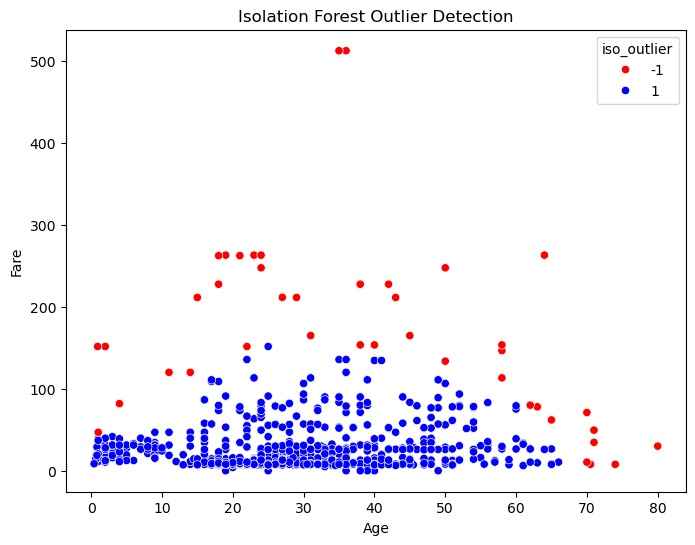

In [29]:
from sklearn.ensemble import IsolationForest

# 初始化孤立森林模型（假设5%的数据是异常值）
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_labels = iso_forest.fit_predict(X_scaled)  # -1表示异常值

# 将结果添加到DataFrame
df['iso_outlier'] = iso_labels
iso_outliers = df[df['iso_outlier'] == -1]

# 输出结果
print(f"[Isolation Forest] 异常值数量: {len(iso_outliers)}")

# 可视化异常值分布（以年龄和票价为例）
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['age'], y=df['fare'], hue=df['iso_outlier'], palette={1: 'blue', -1: 'red'})
plt.title('Isolation Forest Outlier Detection')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.show()
# b站关注动手哥123

### One-Class SVM

#### 基本原理

**One-Class SVM** 是一种基于支持向量机（SVM）的无监督学习方法，主要用于异常检测。

One-Class SVM 的目标是找到一个超平面，将大部分数据包围在其中，从而把与正常样本差异很大的点识别为异常点。

#### 算法流程

- **训练阶段**：
    - 使用“正常数据”训练模型。
    - 寻找一个边界（通常是一个高维超平面）来包围这些数据。
- **预测阶段**：
    - 若新数据在边界内 → 被认为是正常。
    - 若落在边界之外 → 判为异常。

#### OneClassSVM()

- `kernel`: 核函数类型。用于将输入空间映射到高维空间
    - `linear`：线性核
    - `poly`：多项式核
    - `rbf`（默认）：高斯径向基核
    - `sigmoid`: sigmoid核
- `degree`: 多项式核的次数。仅当 kernel=`poly` 时有效
- `gamma`: 核函数系数
- `coef0`: 核函数的常数项
- `nu`: 上限异常率参数。值在 (0,1) 之间，表示模型允许的异常点最大比例
- `verbose`: 控制输出信息的详细程度
    - `0`：不输出
    - `1`：每轮迭代打印损失值
- `max_iter`: 最大迭代次数。默认为 -1 表示无限制

#### OneClassSVM()方法

| 方法名                           | 功能       | 说明                                              |
| ----------------------------- | -------- | ----------------------------------------------- |
| **`.fit(X, y=None)`**         | 拟合模型     | 用训练数据 `X` 拟合一类 SVM，仅使用正常样本。                     |
| **`.predict(X)`**             | 预测异常点    | 返回数组，取值为：<br> - `1` 表示正常<br> - `-1` 表示异常        |
| **`.fit_predict(X, y=None)`** | 拟合并预测    | 相当于先 `.fit()` 再 `.predict()`          |
| **`.decision_function(X)`**   | 距离边界的函数值 | 返回每个样本到 SVM 决策边界的距离（值越小越异常，可为负）。                |
| **`.score_samples(X)`**       | 样本得分     | 返回原始的异常评分，通常和 `decision_function()` 类似，适合绘图或排名。 |
| **`.get_params()`**           | 获取参数     | 返回模型初始化时的参数字典。                                  |

#### 代码实现

[One-Class SVM] 异常值数量: 47


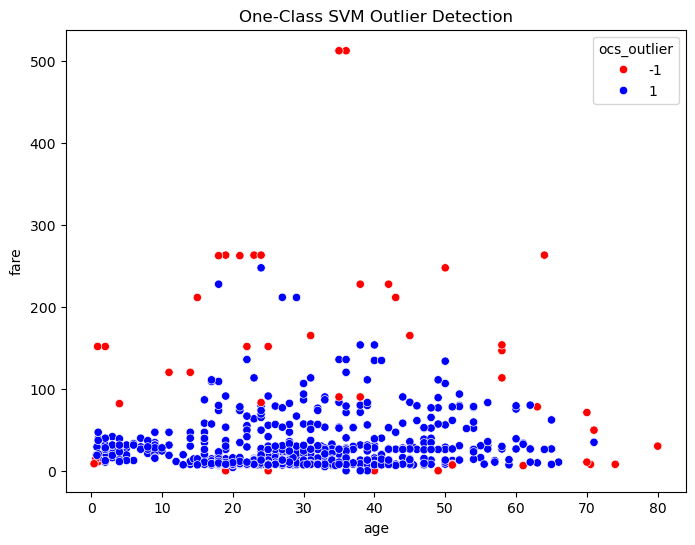

In [30]:
from sklearn.svm import OneClassSVM

# One-Class SVM训练（假设5%异常）
ocs = OneClassSVM(nu=0.05, kernel='rbf')
# b站关注动手哥123
df['ocs_outlier'] = ocs.fit_predict(X_dbscan_scaled)  # -1表示异常值

# 统计异常值
ocs_outliers = df[df['ocs_outlier'] == -1]
print(f"[One-Class SVM] 异常值数量: {len(ocs_outliers)}")

# 可视化
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['age'], y=df['fare'], hue=df['ocs_outlier'], palette={1: 'blue', -1: 'red'})
plt.title('One-Class SVM Outlier Detection')
plt.show()

# 异常值可视化方法

## 箱线图（Boxplot）

直观显示数据的四分位数、中位数及异常值范围

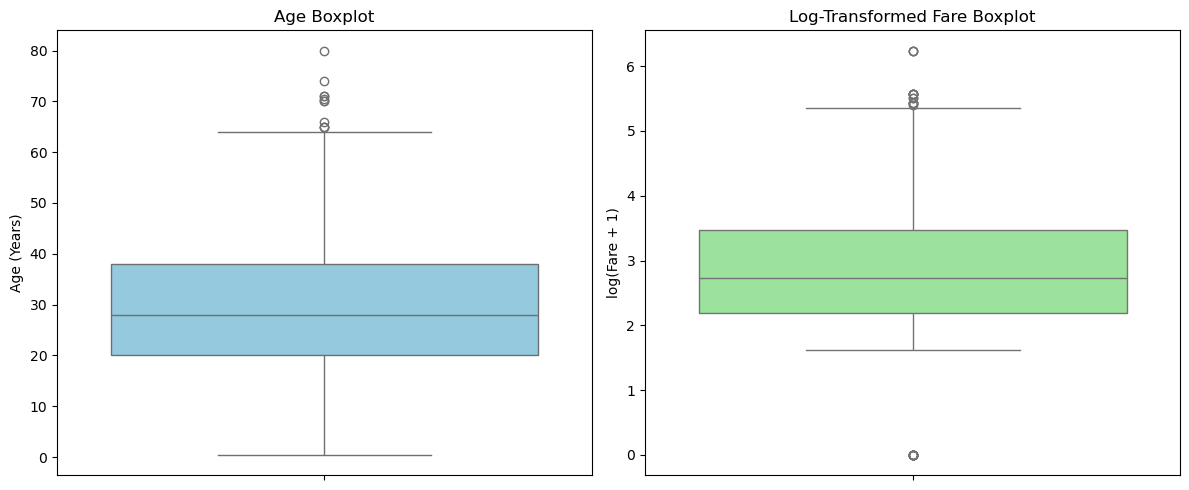

In [31]:
# 设置画布
plt.figure(figsize=(12, 5))

# 1.1 年龄箱线图
plt.subplot(1, 2, 1)
sns.boxplot(y=df['age'], color='skyblue')
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

# 1.2 票价箱线图（对数变换后更清晰）
plt.subplot(1, 2, 2)
sns.boxplot(y=np.log1p(df['fare']), color='lightgreen')  # log(1+x)避免负值
plt.title('Log-Transformed Fare Boxplot')
plt.ylabel('log(Fare + 1)')

plt.tight_layout()
plt.show()

- 左图：年龄箱线图显示少量高年龄异常值（>65岁）。
- 右图：票价对数变换后，极端高值（如512英镑）仍被标记为异常点（箱体外点）。

## 散点图

观察数据分布和离群点

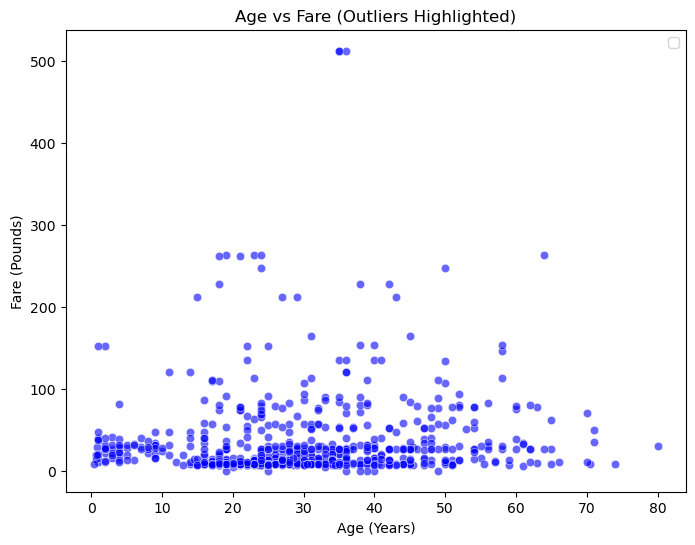

In [33]:
# 基础散点图（年龄 vs 票价）
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['age'], y=df['fare'], alpha=0.6, color='blue')
plt.title('Age vs Fare (Outliers Highlighted)')
plt.xlabel('Age (Years)')
plt.ylabel('Fare (Pounds)')
plt.legend()
plt.show()

- 红色虚线标出IQR定义的票价异常边界，右上角高票价点明显偏离主体分布

## 直方图

观察数据分布和离群点

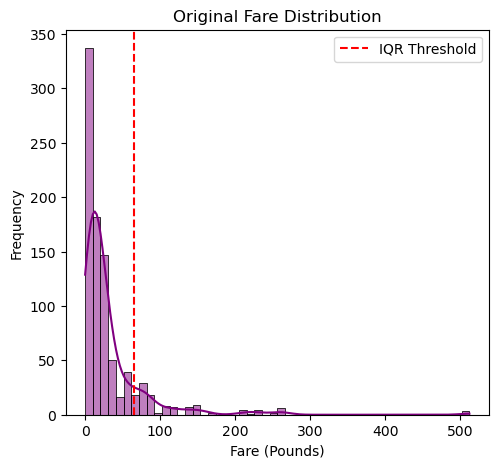

In [34]:
# 设置画布
plt.figure(figsize=(12, 5))

# 原始票价直方图（严重右偏）
plt.subplot(1, 2, 1)
sns.histplot(df['fare'], bins=50, kde=True, color='purple')
plt.title('Original Fare Distribution')
plt.xlabel('Fare (Pounds)')
plt.ylabel('Frequency')
plt.axvline(x=upper_bound, color='red', linestyle='--', label='IQR Threshold')  # IQR异常阈值
plt.legend()

# 异常值处理方法

## 删除（Deletion）

- 直接删除异常样本：当异常值数量极少且确认是错误数据时使用。
- **风险**：可能丢失重要信息，尤其是数据量小或异常值代表真实事件时。

In [35]:
# 方法1：删除Z-Score检测的年龄异常值
df_no_age_outliers = df[df['age_zscore'].abs() <= z_threshold]

# 方法2：删除IQR检测的票价异常值
df_no_fare_outliers = df[(df['fare'] >= lower_bound) & (df['fare'] <= upper_bound)]

# 输出处理后的数据量
print(f"原始数据量: {len(df)}")
print(f"删除年龄异常值后: {len(df_no_age_outliers)}")
print(f"删除票价异常值后: {len(df_no_fare_outliers)}")

原始数据量: 891
删除年龄异常值后: 712
删除票价异常值后: 773


## 替换（Imputation）

### 均值填充

用非异常数据的均值替换异常值

In [36]:
df_mean = df.copy()
# 计算年龄均值
mean_age = df_mean['age'].mean()

# 替换Z-Score异常的年龄值为均值
df_mean['age_imputed'] = np.where(
    df_mean['age_zscore'].abs() > z_threshold,  # 条件：是否为异常值
    mean_age,                            # 异常值替换为中位数
    df_mean['age']                              # 非异常值保留原值
)

# 验证替换结果
replaced_age_count = (df_mean['age_imputed'] == mean_age).sum()
print(f"被替换的年龄异常值数量: {replaced_age_count}")

被替换的年龄异常值数量: 2


### 中位数填充

用非异常数据的中位数替换异常值

In [37]:
df_median = df.copy()
# 计算年龄中位数
median_age = df_median['age'].median()

# 替换Z-Score异常的年龄值为中位数
df_median['age_imputed'] = np.where(
    df_median['age_zscore'].abs() > z_threshold,  # 条件：是否为异常值
    median_age,                            # 异常值替换为中位数
    df_median['age']                              # 非异常值保留原值
)

# 验证替换结果
replaced_age_count = (df_median['age_imputed'] == median_age).sum()
print(f"被替换的年龄异常值数量: {replaced_age_count}")

被替换的年龄异常值数量: 27


### 分位数填充

用特定分位数（如5%或95%）替换超出阈值的数据

In [38]:
# 定义分位数填充函数
def quantile_fill(series, lower_quant=0.05, upper_quant=0.95):
    lower_bound = series.quantile(lower_quant)
    upper_bound = series.quantile(upper_quant)
    return series.clip(lower_bound, upper_bound)

# 对票价进行分位数填充（替换极端值）
df['fare_quantile_filled'] = quantile_fill(df['fare'])

# 对比原始和填充后的最大值
print(f"原始票价最大值: {df['fare'].max():.2f}")
print(f"分位数填充后最大值: {df['fare_quantile_filled'].max():.2f}")

原始票价最大值: 512.33
分位数填充后最大值: 112.08


## 转换（Transformation）

### 对数变换

压缩数据范围，减少极端值影响（适用于右偏分布）

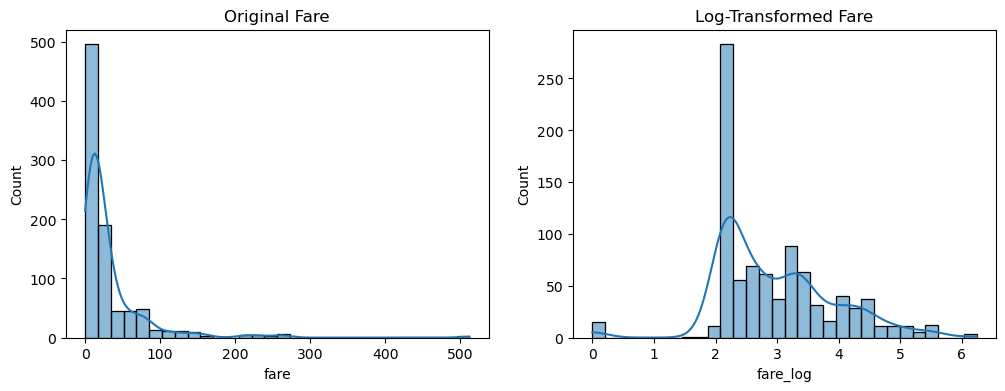

In [39]:
# 对票价进行对数变换（+1避免log(0)）
df['fare_log'] = np.log1p(df['fare'])

# 对比原始和变换后的分布
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['fare'], kde=True, bins=30)
plt.title('Original Fare')
plt.subplot(1, 2, 2)
sns.histplot(df['fare_log'], kde=True, bins=30)
plt.title('Log-Transformed Fare')
plt.show()

### 分箱（Binning）

将连续数据离散化，如按百分位分箱

age_binned
Child      164
Senior     144
Elderly    142
Young      137
Adult      127
Name: count, dtype: int64


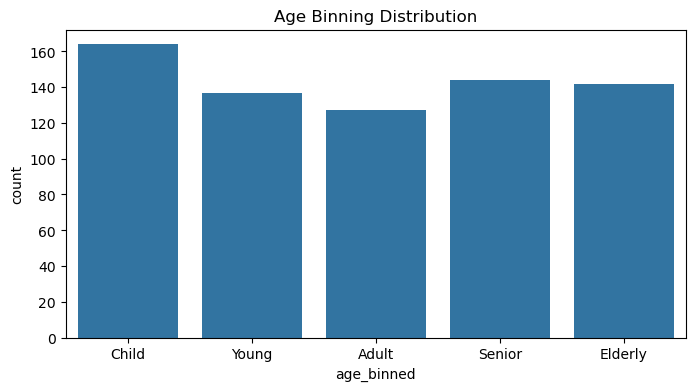

In [40]:
# 对年龄分箱（等频分箱，5组）
df['age_binned'], bins = pd.qcut(
    df['age'], 
    q=5, 
    labels=['Child', 'Young', 'Adult', 'Senior', 'Elderly'],
    retbins=True,
    duplicates='drop'
)

# 查看分箱分布
print(df['age_binned'].value_counts())

# 可视化分箱结果
plt.figure(figsize=(8, 4))
sns.countplot(x='age_binned', data=df, order=['Child', 'Young', 'Adult', 'Senior', 'Elderly'])
plt.title('Age Binning Distribution')
plt.show()

### Winsorization（缩尾处理）

将超出$[Q1 - k \times IQR,\ Q3 + k \times IQR]$的值截断为边界值（常用k=1.5）

In [41]:
import numpy as np

# 设置缩尾因子 k（常用为 1.5）
k = 1.5

# 计算 Q1, Q3 和 IQR
q1 = df['fare'].quantile(0.25)
q3 = df['fare'].quantile(0.75)
iqr = q3 - q1

# 计算下边界和上边界
lower_bound = q1 - k * iqr
upper_bound = q3 + k * iqr

# 将超出范围的值截断为边界值
df['fare_winsorized'] = np.where(df['fare'] < lower_bound, lower_bound,
                          np.where(df['fare'] > upper_bound, upper_bound, df['fare']))

# 验证处理效果
print(f"原始票价最大值: {df['fare'].max():.2f}")
print(f"缩尾后票价最大值: {df['fare_winsorized'].max():.2f}")
print(f"原始票价最小值: {df['fare'].min():.2f}")
print(f"缩尾后票价最小值: {df['fare_winsorized'].min():.2f}")


原始票价最大值: 512.33
缩尾后票价最大值: 65.63
原始票价最小值: 0.00
缩尾后票价最小值: 0.00


## 分区建模（Segmented Modeling）

**分区建模**是一种将数据集划分为若干子区域（比如正常值和异常值两部分），并分别对每个子区域独立建立模型的方法，常用于提高模型的精度、鲁棒性与解释性（如金融欺诈检测中区分正常和欺诈交易）。这样可以解决全局模型难以适应局部变化的问题。

### 适用场景
- 数据具有明显的群组、层级、簇结构、离群点。
- 异常的定义在不同子群中不一样（例如：不同设备、用户、地区、时段）。
- 全局模型过于粗糙，不能捕捉局部异常。

| 场景     | 分区方式             |
| ------ | ---------------- |
| 工业设备监控 | 按设备编号分区，每个设备单独建模 |
| 银行欺诈检测 | 按客户类型或国家划分建模     |
| 网络入侵检测 | 按子网或端口划分建模       |
| 电商风控   | 按用户群体或商品类别建模     |


### 分区建模流程
- **分区（Partitioning）**
    - 按照规则或伪标签算法将数据分为多个子集。
- **局部建模（Modeling per partition）**
    - 在每个子集上分别训练模型。
- **预测与合并（Scoring & Aggregation）**
    - 对新样本，先判断其属于哪个分区；
    - 使用该分区对应模型进行预测。

### 分区建模优缺点
- 优点
    - 局部适应性强：每个分区有独立的模型，适合异构数据。
    - 可解释性增强：模型预测结果可以溯源到对应的子模型。
- 缺点
    - 模型复杂度高：每个分区都要单独训练和维护模型。
    - 分区质量依赖强：若分区不合理，模型表现会下降。
    - 实时预测难度增加：需要先进行分区判断，再用对应模型预测。

## 使用鲁棒模型

- 选择对异常值不敏感的模型： 
    - 树模型（如随机森林、XGBoost、LightGBM）对异常值有一定鲁棒性